In [2]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import cv2
import itertools
import os 
import xml.etree.ElementTree as ET

c:\Users\Sai venkatesh\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def convert_box(size, box):
    dw, dh = 1. / size[0], 1. / size[1]
    x, y, w, h = (box[0] + box[1]) / 2.0 - 1, (box[2] + box[3]) / 2.0 - 1, box[1] - box[0], box[3] - box[2]
    return x * dw, y * dh, w * dw, h * dh

In [ ]:
def convert_voc_to_yolo():
    for anno in os.listdir('./data/labels'):
        if anno.split('.')[1] == 'xml':
            file_name = anno.split('.')[0]
            out_file = open(f'./data/labels/{file_name}.txt', 'w')

            tree = ET.parse(os.path.join('data','labels', anno))
            root = tree.getroot()
            size = root.find('size')        
            w = int(size.find('width').text)
            h = int(size.find('height').text)

            names = ['trafficlight', 'speedlimit', 'crosswalk', 'stop']

            for obj in root.iter('object'):
                cls = obj.find('name').text
                if cls in names and int(obj.find('difficult').text) != 1:
                    xmlbox = obj.find('bndbox')
                    bb = convert_box((w, h), [float(xmlbox.find(x).text) for x in ('xmin', 'xmax', 'ymin', 'ymax')])
                    cls_id = names.index(cls)  # class id
                    out_file.write(" ".join([str(a) for a in (cls_id, *bb)]) + '\n')

In [6]:
convert_voc_to_yolo() 

In [ ]:
%cd yolov5
!python train.py --img 320 --batch 16 --epochs 50 --data VOC.yaml --weights yolov5s.pt --workers 2

In [13]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path='./yolov5/runs/train/exp4/weights/best.pt', force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\Sai venkatesh/.cache\torch\hub\master.zip
YOLOv5  2022-12-22 Python-3.10.2 torch-1.12.1+cu116 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)

Fusing layers... 
Model summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


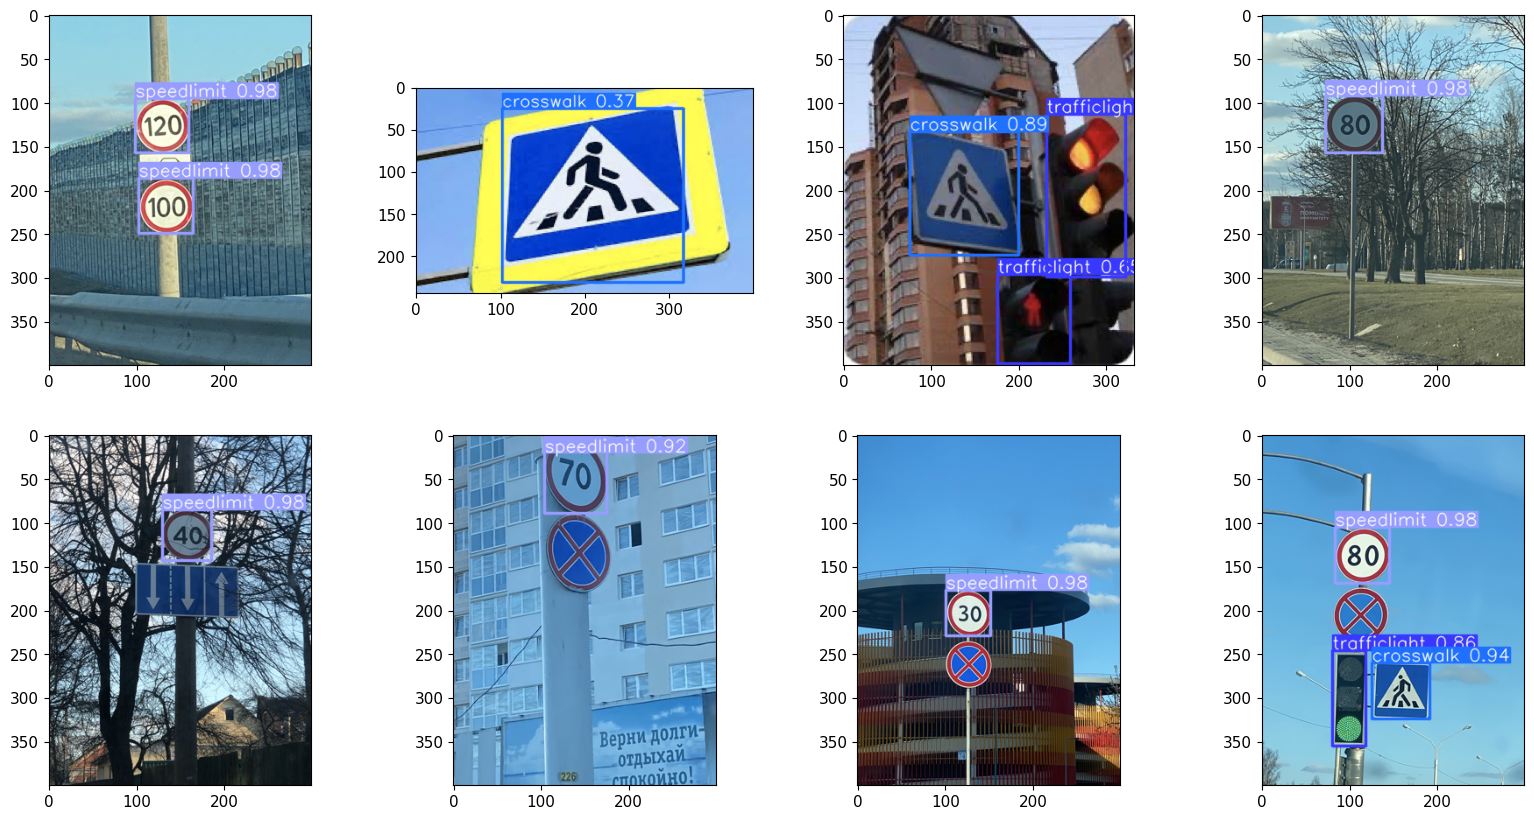

In [19]:
%matplotlib inline
fig, ax = plt.subplots(2,4, figsize=(20,10))
imgs = os.listdir('./data/images')

for idx in itertools.product(range(2),range(4)): 
    imgname = np.random.choice(imgs)
    img = cv2.imread(f'./data/images/{imgname}')
    results = model(img)
    ax[idx[0],idx[1]].imshow(cv2.cvtColor(np.squeeze(results.render()), cv2.COLOR_BGR2RGB))